# LIME to Inspect Image & Text Classification 

This tutorial focuses on showing how to use Local Interpretable Model-agnostic Explanations (LIME) to understand neural models. It is divided into two independent sections for the image and text classification tasks respectively. 

In [1]:
import torch
import torch.nn.functional as F

from captum.attr import visualization as viz
from captum.attr import Lime

import os
import json

## 1. Image Classification

In this section, we will learn applying Lime to analyze a Resnet trained on ImageNet-1k. For testing data, we use samples from PASCAL VOC 2012 since its segmentation masks can directly serve as semantic "super-pixels" ofr images. 

In [2]:
from torchvision.models import resnet18
from torchvision.datasets import VOCSegmentation
import torchvision.transforms as T

from PIL import Image
import matplotlib.pyplot as plt

### 1.1 Load the model and dataset

We can directly load the pretrained Resnet from torchvision and set it to evaluation mode as our target image classifier to inspect. 

In [3]:
resnet = resnet18(pretrained=True)
resnet = resnet.eval()

This model predicts ImageNet-1k labels for given sample images. To better present the results, we also load the mapping of label index and text.

In [4]:
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2021-06-10 10:56:12--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving fwdproxy (fwdproxy)... 2401:db00:21ff:ff2f:face:b00c:0:1e10
Connecting to fwdproxy (fwdproxy)|2401:db00:21ff:ff2f:face:b00c:0:1e10|:8080... connected.
Proxy request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘/home/aoboyang/.torch/models/imagenet_class_index.json.10’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.02s   

2021-06-10 10:56:13 (2.22 MB/s) - ‘/home/aoboyang/.torch/models/imagenet_class_index.json.10’ saved [35363/35363]



In [5]:
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = {idx: label for idx, [_, label] in json.load(json_data).items()}

As mentioned before, we will use PASCAL VOC 2012 as the test data, which is available in torchvision as well. 

In [6]:
root = "./VOC"
dataset = VOCSegmentation(
    root,
    year='2012',
    image_set='train',
    download=False,
    transform=None,
    target_transform=None
)


This dataset provides an addional segmentation mask along with every image. Compared with inspecting each pixel, the segments (or "super-pixels") are semantically more intuitive for human to perceive. We will discuss more in section 3.

Let's pick one example to see how the image and corresponding mask look like. Here we choose an image with more than one segments besides background so that we can compare each segment's impact on the classification.

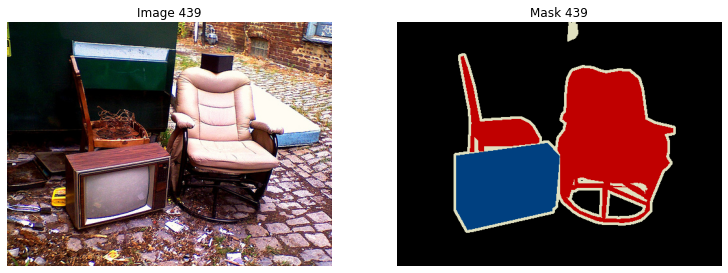

In [7]:
sample_idx = 439

def show_image(ind): 
    fig, ax = plt.subplots(1, 2, figsize=[6.4 * 2, 4.8])
    for i, (name, source) in enumerate(zip(['Image', 'Mask'], [dataset.images, dataset.masks])):
        img = Image.open(source[ind])
        ax[i].imshow(img);
        ax[i].set_title(f"{name} {ind}")
        ax[i].axis('off')

show_image(sample_idx)

### 1.2 Baseline classification

In the section, we will define our classification function which takes in an image and returns the prediction probabilities. 

The original Resnet only gives the logits of labels, so we will add a softmax layer to normalize them into probabilities. 

In [8]:
# uses torchvision transforms to convert a PIL image to a tensor and normalize it
img_to_input = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )    
])

def classify(img, print_result=True):
    output = resnet(img_to_input(img).unsqueeze(0))
    return F.softmax(output, dim=1).squeeze(0)

Then let us test it on the above sample image. We present the top 5 predicted labels to verify the result.

In [9]:
img, seg_mask = Image.open(dataset.images[sample_idx]), Image.open(dataset.masks[sample_idx])

def print_result(probs, topk=1):
    probs, label_indices = torch.topk(probs, topk)
    probs = probs.tolist()
    label_indices = label_indices.tolist()
    for prob, idx in zip(probs, label_indices):
        label = idx_to_labels[str(idx)]
        print(f'{label} ({idx}):', round(prob, 4))
        
output_probs = classify(img)
print_result(output_probs, topk=5)

television (851): 0.083
screen (782): 0.0741
monitor (664): 0.0619
laptop (620): 0.0421
ashcan (412): 0.03


As we can see, the result is pretty reasonable.

## 1.3 Inspect the model prediction with Lime

In this section, we will bring in LIME from Captum to analyze how the Resnet made above prediction based on the sample image.

Like many other Captum algorithms, Lime also support analyzing a number of input features together as a group. This is very useful when dealing with images, where each color channel in each pixel is an input feature. Such group is also refered as "super-pixel". To define our desired groups over input features, all we need is to provide a feature mask.

In case of an image input, the feature mask is a 2D image of the same size, where each pixel in the mask indicates the feature group it belongs to via an integer value. Pixels of the same value define a group.

This means we can readily use POV's segmentation masks as feature masks for Captum! However, while segmentaion numbers range from 0 to 255, Captum prefers consecutive group ids for efficiency. Therefore, we will also include extra steps to convert mask IDs.

In [10]:
# convert the segmentation mask to a tensor of shape (batch, channels, height, width)
feature_mask = torch.tensor(seg_mask.getdata()).reshape(1, 1, seg_mask.size[1], seg_mask.size[0])
seg_ids = sorted(feature_mask.unique().tolist())
print('Segmentation IDs:', seg_ids)

for i, seg_id in enumerate(seg_ids):
    feature_mask[feature_mask == seg_id] = i
    
print('Feature mask IDs:', feature_mask.unique().tolist())

Segmentation IDs: [0, 9, 20, 255]
Feature mask IDs: [0, 1, 2, 3]


Next, we will analyze these groups' influence on the most confident prediction `television`. Essentially, Lime trains an interpretable surrogate model to simulate the target model's predictions. So, building an appropriate interpretable model is the most critical step in Lime. Fortunately, Captum has provided many most common interpretable models to save the efforts. We will demonstrate the usages of Linear Regression and Linear Lasso. Everytime we call Lime's `attribute` function, an interpretable model is trained around the given input, so unlike many other Captum's attribution algorithms, it is strongly recommended to only provide a single example as input (tensors with first dimension or batch size = 1). There are advanced use cases of passing batched inputs. Interested readers can check the [document](https://captum.ai/api/lime.html) for details.

In order to train the interpretable model, we need to specify enough training data through the argument `n_samples`. Lime creates the pertubed samples in the form of interpretable representation, i.e., a binary vector indicating the “presence” or “absence” of features. Since our simple example only has 4 segments, a small number can easily cover all possible combinations. Lime needs to keep calling the target model to get the labels/values for all pertubed samples. This process can be quite time-consuming depending on the complexity of the target model and the number of samples. Setting the `perturbations_per_eval` can parallel the sampling to shorten the process as long as your machine still has capaciity. You may also consider turning on the flag `show_progress` to display a progess bar showing how many forward calls are left.

In [11]:
# import the build-in wrapped sklearn Linear Regression and Linear Lasso
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso

lr_lime = Lime(resnet, interpretable_model=SkLearnLinearRegression())

# add & remove dummy batch dimension before & after attribution
attrs = lr_lime.attribute(
    img_to_input(img).unsqueeze(0),
    target=output_probs.argmax().unsqueeze(0),
    feature_mask=feature_mask,
    n_samples=100,
    perturbations_per_eval=16,
    show_progress=True,
    return_input_shape=True,
).squeeze(0)

print('Attribution range:', attrs.min().item(), 'to', attrs.max().item())

Lime attribution: 100%|██████████| 7/7 [00:15<00:00,  2.16s/it]


Attribution range: -0.4320279061794281 to 2.890782594680786


Now, let us use Captum's visualization tool to view the attribution heat map.

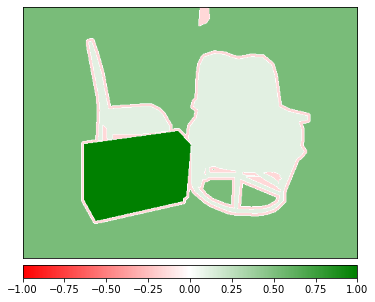

In [12]:
def show_attr(attr_map):
    viz.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),  # adjust shape to height, width, channels 
        method="heat_map",
        sign="all",
        show_colorbar=True
    )
    
show_attr(attrs)

The result looks decent: the television segment does demonstrate strongest positive correlation with the prediction, while the chairs has relatively trivial impact and the border slightly shows negative contribution.

However, we can further improve this result. One desired characteristic of interpretability is the ease for human to comprehend. We should help reduce the noisy interference and emphisze the real influential features. In our case, all features more or less show some influences. Lasso regularization can effectively help us filter them. Therefore, let us try Linear Lasso with a fit coefficient `alpha`. For all build-in sklearn wrapper model, you can directly pass any sklearn supported arguments.

Lime attribution: 100%|██████████| 7/7 [00:16<00:00,  2.33s/it]


Attribution range: -0.08233936876058578 to 2.5164413452148438


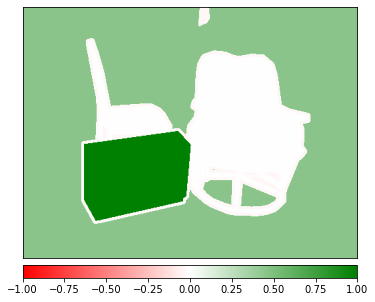

In [13]:
lasso_lime = Lime(resnet, interpretable_model=SkLearnLasso(alpha=0.08))

attrs = lasso_lime.attribute(
    img_to_input(img).unsqueeze(0),
    target=output_probs.argmax().unsqueeze(0),
    feature_mask=feature_mask,
    n_samples=100,
    perturbations_per_eval=16,
    show_progress=True
).squeeze(0)

print('Attribution range:', attrs.min().item(), 'to', attrs.max().item())
show_attr(attrs)

As we can see, the new attribution result removes the chairs and border with the help of Lasso.

Another interesting question to explore is if the model also recognize the chairs in the image. To answer it, we will use the most related label `rocking_chair` from ImageNet as the target, whose label index is `765`. We can check how confident the model feels about the alternative object.

In [14]:
alter_label_idx = 765

alter_prob = output_probs[alter_label_idx].item()
print(f'{idx_to_labels[str(alter_label_idx)]} ({alter_label_idx}):', round(alter_prob, 4))

rocking_chair (765): 0.0048


Then, we will redo the attribution with our Lasso Lime.

Lime attribution: 100%|██████████| 7/7 [00:15<00:00,  2.27s/it]


Attribution range: -0.19933688640594482 to 1.3914614915847778


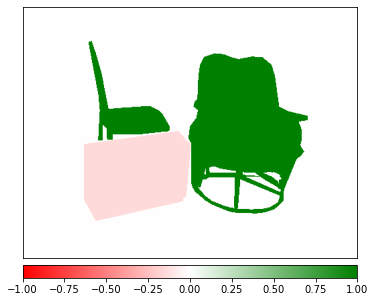

In [15]:
attrs = lasso_lime.attribute(
    img_to_input(img).unsqueeze(0),
    target=765,
    feature_mask=feature_mask,
    n_samples=100,
    perturbations_per_eval=16,
    show_progress=True,
    return_input_shape=True,
).squeeze(0)

print('Attribution range:', attrs.min().item(), 'to', attrs.max().item())
show_attr(attrs)

As shown in the heat map, our ResNet does present right belief about the chair segment. However, it gets hindered by the television segment in the foreground. This may also explain why the model feels less confident about the chairs than the television.